In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required libraries
!pip install wfdb biosppy peakutils pandas numpy scikit-learn xgboost lightgbm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 66.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


In [3]:
# Imports and Dependencies
import os
import numpy as np
import pandas as pd
import pywt
import scipy.stats
import operator
import scipy.io
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as signal
import biosppy.signals.ecg as ecg
from scipy.signal import medfilt
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb
from joblib import Parallel, delayed
import wfdb

# Add these imports at the top
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import VotingClassifier
from collections import Counter # Added Counter import
from imblearn.over_sampling import SMOTE # Added SMOTE import
from sklearn.feature_selection import SelectKBest, f_classif # Added feature selection imports
import numpy as np # Added numpy import
import pandas as pd # Added pandas import
import lightgbm as lgb # Added lightgbm import
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # Added metrics imports
import joblib # Added joblib import
import matplotlib.pyplot as plt # Added matplotlib import
import seaborn as sns # Added seaborn import
import wfdb # Added wfdb import
import os # Added os import
import scipy.signal as signal # Added signal import
import biosppy.signals.ecg as ecg # Added biosppy import
from scipy.signal import medfilt # Added medfilt import
from sklearn.ensemble import RandomForestClassifier # Added RandomForestClassifier import

In [4]:
# Load the Dataset
dataset_paths = [
    "/content/drive/MyDrive/Datasets/mit-bih-arrhythmia-database-1.0.0.zip",
]
extract_path = "/content/ECG_Data/"

# Unzip all files
for dataset_path in dataset_paths:
    if dataset_path.endswith(".zip"):
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

print("All ECG datasets extracted successfully!")
print("Files in dataset folder:", os.listdir(extract_path))

All ECG datasets extracted successfully!
Files in dataset folder: ['mit-bih-arrhythmia-database-1.0.0']


In [5]:
# ECG Data Loader Class
class ECGDataLoader:
    def __init__(self, data_path):
        self.data_path = data_path
        self.aami_mapping = {
            'N': ['N', 'L', 'R'],    # Normal beats
            'SVEB': ['A', 'a', 'J', 'S', 'e', 'j'],    # Supraventricular ectopic beats
            'VEB': ['V', 'E'],    # Ventricular ectopic beats
            'F': ['F'],    # Fusion beats
            'Q': ['/', 'f', 'Q']    # Unknown beats
        }

        # Inter-patient split as defined in the paper
        self.ds1_patients = ['101', '106', '108', '109', '112', '114', '115', '116',
                            '118', '119', '122', '124', '201', '203', '205', '207',
                            '208', '209', '215', '220', '223', '230']
        self.ds2_patients = ['100', '103', '105', '111', '113', '117', '121', '123',
                            '200', '202', '210', '212', '213', '214', '219', '221',
                            '222', '228', '231', '232', '233', '234']

    def load_mit_bih_data(self, record_ids):
        """Load MIT-BIH Arrhythmia data for given record IDs"""
        all_signals = []
        all_annotations = []
        all_rpeaks = []

        for record_id in tqdm(record_ids, desc="Loading records"):
            try:
                # Read record
                record_path = os.path.join(self.data_path, record_id)
                record = wfdb.rdrecord(record_path)
                annotation = wfdb.rdann(record_path, 'atr')

                # Get MLII lead (usually the first lead)
                signal_data = record.p_signal[:, 0]

                # Detect R-peaks using BioSPPy
                rpeaks = ecg.ecg(signal=signal_data, sampling_rate=360, show=False)[2]

                # Map annotations to AAMI classes
                aami_annotations = []
                for symbol in annotation.symbol:
                    aami_class = 'Q'  # Default to unknown
                    for aami_key, symbols in self.aami_mapping.items():
                        if symbol in symbols:
                            aami_class = aami_key
                            break
                    aami_annotations.append(aami_class)

                all_signals.append(signal_data)
                all_annotations.append(aami_annotations)
                all_rpeaks.append(rpeaks)

                print(f"Loaded record {record_id} with {len(rpeaks)} beats")

            except Exception as e:
                print(f"Error loading record {record_id}: {e}")

        return all_signals, all_annotations, all_rpeaks

In [6]:
# Include the full ECGClassifier class definition here with the new method
class ECGClassifier:
    def __init__(self, sampling_rate=360):
        self.sampling_rate = sampling_rate
        self.scalers = {}
        self.models = {}
        self.feature_selector = None

    # ECG Preprocessing
    def preprocess_signal(self, signal):
        """Remove baseline wander using median filters"""
        # Convert window sizes from ms to samples
        window1 = int(0.2 * self.sampling_rate)  # 200ms
        window2 = int(0.6 * self.sampling_rate)  # 600ms

        # Ensure odd window sizes for medfilt
        window1 = window1 if window1 % 2 == 1 else window1 + 1
        window2 = window2 if window2 % 2 == 1 else window2 + 1

        # Apply median filters
        baseline = medfilt(signal, window1)
        baseline = medfilt(baseline, window2)

        # Remove baseline
        processed_signal = signal - baseline
        return processed_signal

    # Feature Extraction Methods (Optimized)
    def extract_wavelet_features(self, beat):
        """Extract wavelet features using db1 wavelet with 3 levels"""
        import pywt # Import inside function to avoid dependency issues if class is moved
        try:
            db1 = pywt.Wavelet('db1')
            coeffs = pywt.wavedec(beat, db1, level=3)
            wavelet_features = coeffs[0][:10]  # Top 10 approximation coefficients
            return wavelet_features
        except:
            return np.zeros(10)

    def extract_hos_features(self, beat, n_intervals=6):
        """Extract Higher Order Statistics features (Optimized without numba)"""
        winL, winR = 90, 90
        lag = int(round((winL + winR) / n_intervals))
        hos_features = np.zeros(10)

        for i in range(n_intervals-1):
            pos = lag * (i+1)
            start_idx = max(0, pos - (lag//2))
            end_idx = min(len(beat), pos + (lag//2))

            if end_idx > start_idx and (end_idx - start_idx) >= 3:
                interval = beat[start_idx:end_idx]
                # Skewness
                mean_val = np.mean(interval)
                std_val = np.std(interval) + 1e-10
                hos_features[i] = np.mean((interval - mean_val)**3) / (std_val**3)
                # Kurtosis
                hos_features[5+i] = np.mean((interval - mean_val)**4) / (std_val**4)

        return np.nan_to_num(hos_features)

    def extract_rr_intervals(self, r_peaks, current_index):
        """Extract RR interval features"""
        rr_features = np.zeros(8)

        if current_index > 0 and current_index < len(r_peaks) - 1:
            # Raw RR intervals
            pre_RR = (r_peaks[current_index] - r_peaks[current_index-1]) / self.sampling_rate
            post_RR = (r_peaks[current_index+1] - r_peaks[current_index]) / self.sampling_rate
            local_RR = (r_peaks[current_index+1] - r_peaks[current_index-1]) / self.sampling_rate

            # Global RR
            start_idx = max(0, current_index - 10)
            if current_index - start_idx > 0:
                global_RR = np.mean(np.diff(r_peaks[start_idx:current_index+1])) / self.sampling_rate
            else:
                global_RR = pre_RR

            rr_features[:4] = [pre_RR, post_RR, local_RR, global_RR]

        return np.nan_to_num(rr_features)

    def extract_features_from_record(self, signal, r_peaks, annotations):
        """Optimized feature extraction"""
        all_features = []
        all_labels = []

        winL, winR = 90, 90
        processed_signal = self.preprocess_signal(signal)

        for i, r_pos in enumerate(r_peaks):
            if (r_pos - winL < 0 or r_pos + winR >= len(processed_signal) or
                i >= len(annotations)):
                continue

            # Skip based on RR intervals early
            if i > 0:
                rr_interval = (r_pos - r_peaks[i-1]) / self.sampling_rate
                if rr_interval < 0.15 or rr_interval > 2.0:
                    continue

            beat = processed_signal[r_pos - winL: r_pos + winR]

            # Extract optimized features (reduced set)
            raw_features = beat[::2]  # Downsample by 2 (90 features)
            wavelet_features = self.extract_wavelet_features(beat)  # 10 features
            hos_features = self.extract_hos_features(beat)  # 10 features
            rr_features = self.extract_rr_intervals(r_peaks, i)  # 8 features

            # Total: 90 + 10 + 10 + 8 = 118 features (much faster than 284)
            combined_features = np.concatenate([
                raw_features, wavelet_features, hos_features, rr_features
            ])

            if not np.any(np.isnan(combined_features)):
                all_features.append(combined_features)
                all_labels.append(annotations[i])

        return np.array(all_features), np.array(all_labels)

    def extract_features_from_dataset(self, signals, annotations_list, rpeaks_list, n_jobs=1):
        """Feature extraction without parallel processing to avoid issues"""
        print(f"Extracting features from {len(signals)} records...")

        all_features = []
        all_labels = []

        for i, (signal, annotations, rpeaks) in enumerate(zip(signals, annotations_list, rpeaks_list)):
            # print(f"Processing record {i+1}/{len(signals)}") # Removed for brevity
            features, labels = self.extract_features_from_record(signal, rpeaks, annotations)
            if len(features) > 0:
                all_features.append(features)
                all_labels.append(labels)

        if all_features:
            all_features = np.vstack(all_features)
            all_labels = np.hstack(all_labels)

            # Remove NaN values
            nan_mask = ~np.any(np.isnan(all_features), axis=1)
            all_features = all_features[nan_mask]
            all_labels = all_labels[nan_mask]

            print(f"Final dataset shape: {all_features.shape}")
            return all_features, all_labels

        return np.array([]), np.array([])

    def get_feature_names(self):
        """Return feature names"""
        feature_names = []
        feature_names.extend([f'raw_{i}' for i in range(90)])
        feature_names.extend([f'wavelet_{i}' for i in range(10)])
        feature_names.extend([f'hos_skew_{i}' for i in range(5)] + [f'hos_kurt_{i}' for i in range(5)])
        feature_names.extend(['pre_RR', 'post_RR', 'local_RR', 'global_RR',
                             'norm_pre_RR', 'norm_post_RR', 'norm_local_RR', 'norm_global_RR'])
        return feature_names

    # Add this method to the ECGClassifier class for better minority class handling
    def train_lightgbm_model_improved(self, X_train, y_train, model_name):
        """Improved training with better handling of minority classes"""

        print("Class distribution before balancing:", dict(Counter(y_train)))

        # For very small classes like 'F' with only 8 samples, use alternative strategy
        class_counts = Counter(y_train)
        min_samples = min(class_counts.values())

        if min_samples < 20:  # If any class has fewer than 20 samples
            print("Very small classes detected. Using class weighting instead of SMOTE.")

            # Use class weights to handle imbalance
            class_weights = {cls: sum(class_counts.values()) / (len(class_counts) * count)
                            for cls, count in class_counts.items()}

            # Feature selection
            # Using f_classif might return 0 features if variance is low or classes are too small for test
            # Let's try selecting a fixed number of features directly without f_classif for now
            # Or, let's try a different approach: train without explicit feature selection here
            print("Skipping explicit feature selection in this method.")
            X_selected = X_train
            self.feature_selector = None # Ensure selector is None if not used

            print(f"Using all {X_train.shape[1]} features for training")

            # Train with class weights
            lgb_model = lgb.LGBMClassifier(
                n_estimators=100,
                learning_rate=0.1,
                num_leaves=31,
                max_depth=5,
                min_child_samples=50,
                class_weight=class_weights,
                random_state=42,
                n_jobs=-1,
                verbosity=-1
            )
            # Use original data for training if using class weights instead of SMOTE
            X_train_processed = X_train
            y_train_processed = y_train


        else:
            # Use SMOTE for larger classes
            smote = SMOTE(random_state=42, sampling_strategy='auto')
            X_balanced, y_balanced = smote.fit_resample(X_train, y_train)
            print("Class distribution after SMOTE:", dict(Counter(y_balanced)))

            # Feature selection (optional, can be removed if problematic)
            # Let's still try SelectKBest here where SMOTE has been applied
            k_features = min(30, X_balanced.shape[1])
            try:
                selector = SelectKBest(f_classif, k=k_features)
                X_selected = selector.fit_transform(X_balanced, y_balanced)
                self.feature_selector = selector
                print(f"Selected top {self.feature_selector.get_support().sum()} features using SelectKBest")
            except ValueError as e:
                print(f"SelectKBest failed: {e}. Using all features.")
                X_selected = X_balanced
                self.feature_selector = None

            print(f"Using {X_selected.shape[1]} features for training")


            # Train without class weights (SMOTE already balanced)
            lgb_model = lgb.LGBMClassifier(
                n_estimators=100,
                learning_rate=0.1,
                num_leaves=31,
                max_depth=5,
                min_child_samples=50,
                random_state=42,
                n_jobs=-1,
                verbosity=-1
            )
            X_train_processed = X_selected
            y_train_processed = y_balanced

        print(f"Training {model_name} with improved LightGBM...")
        lgb_model.fit(X_train_processed, y_train_processed)

        self.models[model_name] = lgb_model
        return lgb_model, self.feature_selector # Return model and selector

    # Add this method to the ECGClassifier class for better minority class handling
    def train_final_model(self, X_train, y_train):
        """Final optimized training with ensemble and specialized minority class handling"""

        print("Final training with specialized minority class handling...")
        print("Class distribution:", dict(Counter(y_train)))

        # Separate majority and minority classes
        class_counts = Counter(y_train)
        majority_class = max(class_counts, key=class_counts.get)
        minority_classes = [cls for cls in class_counts.keys() if cls != majority_class]

        # For minority classes with very few samples, use specialized approach
        X_minority = []
        y_minority = []
        X_majority = []
        y_majority = []

        for i, label in enumerate(y_train):
            if label in minority_classes and class_counts[label] < 50:
                X_minority.append(X_train[i])
                y_minority.append(label)
            else:
                X_majority.append(X_train[i])
                y_majority.append(label)

        X_minority = np.array(X_minority)
        y_minority = np.array(y_minority)
        X_majority = np.array(X_majority)
        y_majority = np.array(y_majority)

        # Apply ADASYN only to minority classes with reasonable samples
        if len(X_minority) > 0:
            print(f"Applying ADASYN to {len(minority_classes)} minority classes...")
            # Filter minority classes for ADASYN to avoid errors with single samples
            adasyn_classes = {cls: 500 for cls in minority_classes if class_counts[cls] >= 2} # ADASYN needs at least 2 samples

            if adasyn_classes:
                ada = ADASYN(random_state=42, sampling_strategy=adasyn_classes)
                # Need to apply ADASYN to a subset containing only the classes to be oversampled
                minority_indices_for_adasyn = [i for i, label in enumerate(y_train) if label in adasyn_classes.keys()]
                if minority_indices_for_adasyn:
                    X_adasyn = X_train[minority_indices_for_adasyn]
                    y_adasyn = y_train[minority_indices_for_adasyn]
                    X_minority_balanced, y_minority_balanced = ada.fit_resample(X_adasyn, y_adasyn)

                    # Combine with majority and very small minority classes
                    # Need to handle classes that were too small for ADASYN separately
                    very_small_minority_indices = [i for i, label in enumerate(y_train) if label in minority_classes and class_counts[label] < 2]
                    X_very_small_minority = X_train[very_small_minority_indices]
                    y_very_small_minority = y_train[very_small_minority_indices]


                    X_combined = np.vstack([X_majority, X_minority_balanced, X_very_small_minority])
                    y_combined = np.concatenate([y_majority, y_minority_balanced, y_very_small_minority])

                else: # No minority classes with enough samples for ADASYN
                    X_combined = X_train
                    y_combined = y_train
            else: # No minority classes with enough samples for ADASYN
                X_combined = X_train
                y_combined = y_train

        else: # No minority classes at all
            X_combined = X_train
            y_combined = y_train


        print("Final class distribution after balancing:", dict(Counter(y_combined)))

        # Feature selection
        # Check if X_combined has enough samples and features for SelectKBest
        if X_combined.shape[0] > 0 and X_combined.shape[1] > 0:
            k_features = min(40, X_combined.shape[1])
            try:
                selector = SelectKBest(f_classif, k=k_features)
                X_selected = selector.fit_transform(X_combined, y_combined)
                self.feature_selector = selector
                print(f"Selected top {self.feature_selector.get_support().sum()} features from {X_combined.shape[1]} total features")
            except ValueError as e:
                 print(f"SelectKBest failed: {e}. Using all features.")
                 X_selected = X_combined
                 self.feature_selector = None

        else:
             print("Warning: X_combined is empty or has no features. Skipping feature selection.")
             X_selected = X_combined
             self.feature_selector = None


        # Create ensemble of models
        rf_model = RandomForestClassifier(
            n_estimators=150,
            max_depth=12,
            min_samples_split=8,
            min_samples_leaf=4,
            class_weight='balanced_subsample',
            random_state=42,
            n_jobs=-1
        )

        lgb_model = lgb.LGBMClassifier(
            n_estimators=100,
            learning_rate=0.05,
            num_leaves=63,
            max_depth=8,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbosity=-1
        )

        # Voting classifier
        ensemble = VotingClassifier(
            estimators=[('rf', rf_model), ('lgb', lgb_model)],
            voting='soft',
            n_jobs=-1
        )

        print("Training final ensemble model...")
        ensemble.fit(X_selected, y_combined)

        return ensemble

    # Replace the predict method to handle the feature selector
    def predict(self, X_test, model_name):
        """Predict using a specific model with feature selection"""
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} not found")

        # Remove NaN values
        nan_mask = ~np.any(np.isnan(X_test), axis=1)
        X_test_clean = X_test[nan_mask]

        # Apply feature selection if a selector exists
        if self.feature_selector is not None:
             # Check if the selector actually selected any features
            if self.feature_selector.get_support().sum() > 0:
                X_test_processed = self.feature_selector.transform(X_test_clean)
            else:
                print("Warning: Feature selector selected zero features. Cannot transform test data.")
                # If no features were selected during training, predict on raw test data
                X_test_processed = X_test_clean
        else:
            # If no feature selector was used during training, use original features
            X_test_processed = X_test_clean


        return self.models[model_name].predict(X_test_processed)

    # Add this method for probability predictions (handle feature selector)
    def predict_proba(self, X_test, model_name):
        """Get probability predictions"""
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} not found")

        nan_mask = ~np.any(np.isnan(X_test), axis=1)
        X_test_clean = X_test[nan_mask]

        # Apply feature selection if a selector exists
        if self.feature_selector is not None:
            if self.feature_selector.get_support().sum() > 0:
                X_test_processed = self.feature_selector.transform(X_test_clean)
            else:
                print("Warning: Feature selector selected zero features. Cannot transform test data for prob prediction.")
                X_test_processed = X_test_clean
        else:
             X_test_processed = X_test_clean

        return self.models[model_name].predict_proba(X_test_processed)

Running with improved training method...
Using balanced subset of patients...
Loading training data...


Loading records:  10%|█         | 1/10 [00:06<00:54,  6.06s/it]

Loaded record 101 with 1866 beats


Loading records:  20%|██        | 2/10 [00:09<00:36,  4.62s/it]

Loaded record 106 with 1943 beats


Loading records:  30%|███       | 3/10 [00:13<00:30,  4.30s/it]

Loaded record 108 with 1783 beats


Loading records:  40%|████      | 4/10 [00:21<00:35,  5.90s/it]

Loaded record 109 with 2523 beats


Loading records:  50%|█████     | 5/10 [00:27<00:28,  5.64s/it]

Loaded record 112 with 2538 beats


Loading records:  60%|██████    | 6/10 [00:32<00:21,  5.49s/it]

Loaded record 114 with 1839 beats


Loading records:  70%|███████   | 7/10 [00:36<00:15,  5.20s/it]

Loaded record 115 with 1952 beats


Loading records:  80%|████████  | 8/10 [00:38<00:08,  4.13s/it]

Loaded record 116 with 2391 beats


Loading records:  90%|█████████ | 9/10 [00:40<00:03,  3.38s/it]

Loaded record 118 with 2277 beats


Loading records: 100%|██████████| 10/10 [00:42<00:00,  4.20s/it]


Loaded record 119 with 1987 beats
Loading test data...


Loading records:  20%|██        | 1/5 [00:01<00:07,  1.83s/it]

Loaded record 100 with 2272 beats


Loading records:  40%|████      | 2/5 [00:03<00:05,  1.83s/it]

Loaded record 103 with 2080 beats


Loading records:  60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

Loaded record 105 with 2591 beats


Loading records:  80%|████████  | 4/5 [00:08<00:02,  2.14s/it]

Loaded record 111 with 2121 beats


Loading records: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]

Loaded record 113 with 1794 beats
Extracting training features...
Extracting features from 10 records...


Final dataset shape: (21055, 118)
Extracting test features...
Extracting features from 5 records...
Final dataset shape: (10854, 118)
Training set: (21055, 118), Test set: (10854, 118)
Training class distribution: {'N': 19528, 'Q': 300, 'SVEB': 113, 'VEB': 1106, 'F': 8}
Test class distribution: {'N': 10633, 'SVEB': 41, 'VEB': 43, 'Q': 137}
Class distribution before balancing: {np.str_('N'): 19528, np.str_('Q'): 300, np.str_('SVEB'): 113, np.str_('VEB'): 1106, np.str_('F'): 8}
Very small classes detected. Using class weighting instead of SMOTE.
Skipping explicit feature selection in this method.
Using all 118 features for training
Training improved_model with improved LightGBM...
Making predictions with improved model...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Improved Model Performance:
              precision    recall  f1-score   support

           N       0.98      0.83      0.90     10633
           Q       0.07      0.20      0.10       137
        SVEB       0.00      0.00      0.00        41
         VEB       0.00      0.05      0.00        43

    accuracy                           0.81     10854
   macro avg       0.26      0.27      0.25     10854
weighted avg       0.96      0.81      0.88     10854

Confusion Matrix:
[[8815  387    1 1430]
 [ 104   28    0    5]
 [  40    0    0    1]
 [  33    8    0    2]]
Improved Accuracy: 0.8149

Top 10 most important features:
1. global_RR: 364.0000
2. pre_RR: 228.0000
3. raw_24: 215.0000
4. raw_19: 215.0000
5. post_RR: 169.0000
6. hos_kurt_0: 167.0000
7. hos_skew_1: 157.0000
8. hos_kurt_1: 155.0000
9. hos_kurt_2: 154.0000
10. raw_89: 152.0000

Trying Random Forest as alternative...

Random Forest Performance:
              precision    recall  f1-score   support

           N       0.9

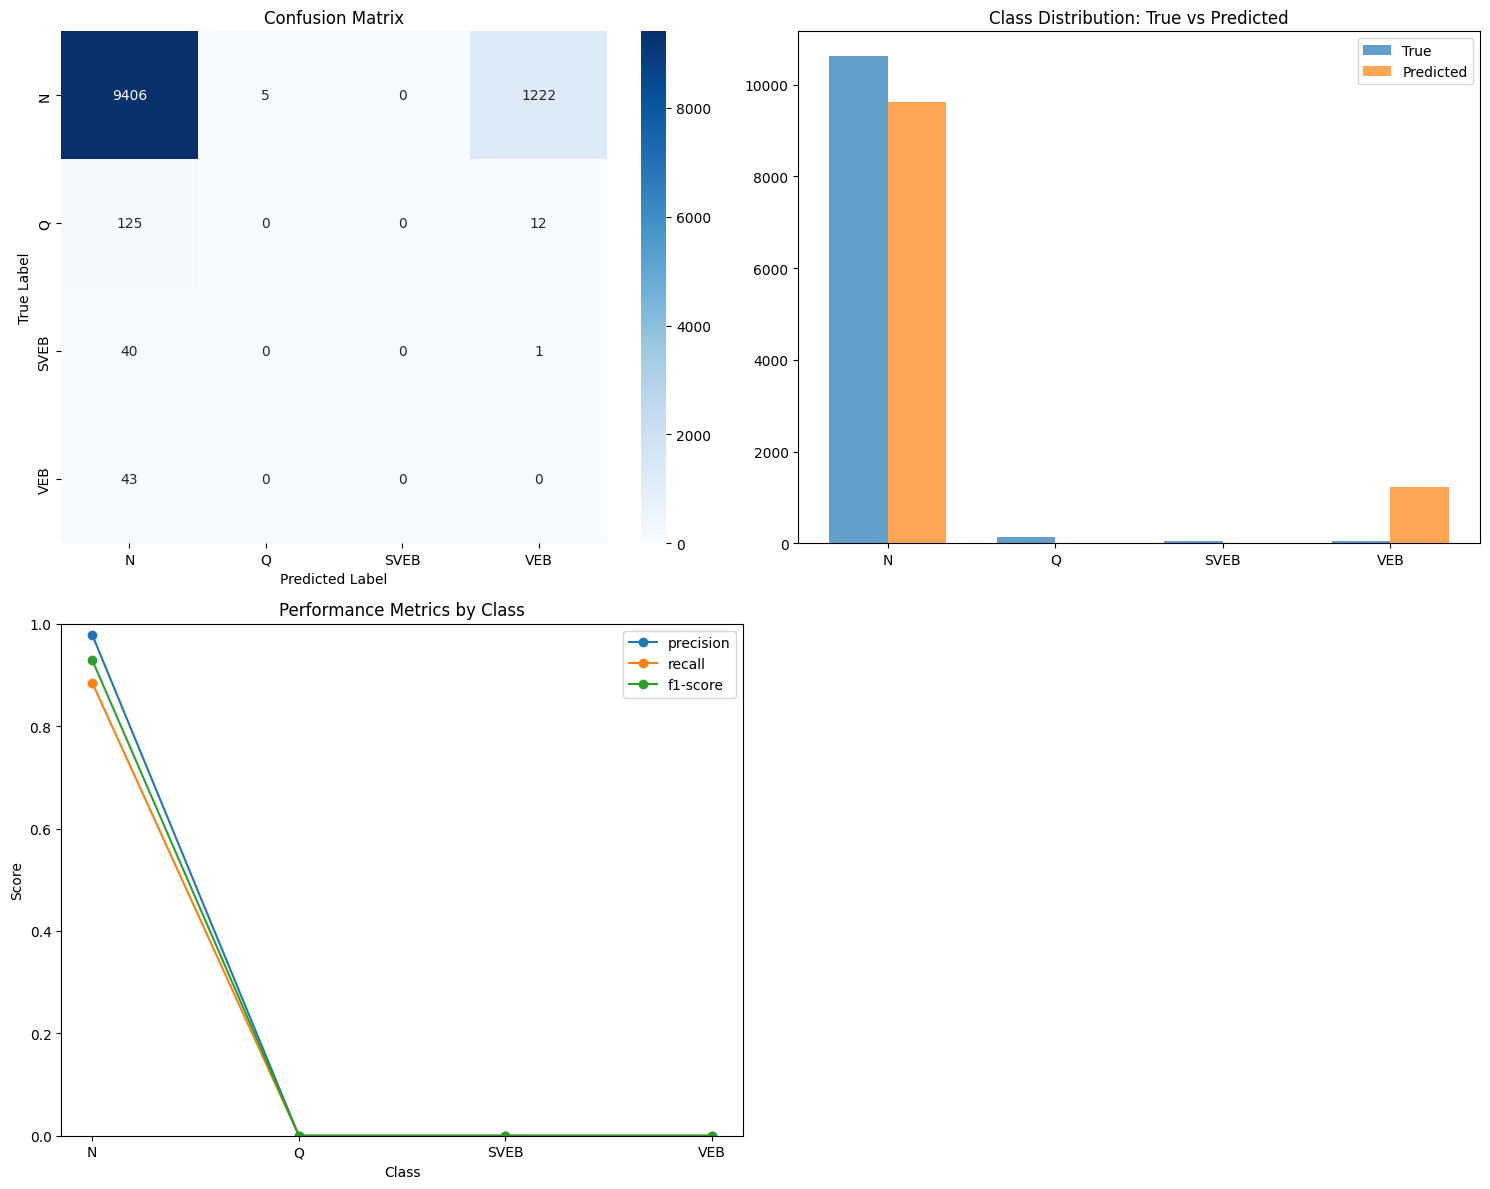


Detailed Class-wise Performance:
N: Precision=0.978, Recall=0.885, F1=0.929, Support=10633.0
Q: Precision=0.000, Recall=0.000, F1=0.000, Support=137.0
SVEB: Precision=0.000, Recall=0.000, F1=0.000, Support=41.0
VEB: Precision=0.000, Recall=0.000, F1=0.000, Support=43.0
Running improved ECG classification pipeline with better minority class handling...


In [7]:
# Enhanced visualization function
def plot_results(y_true, y_pred):
    """Enhanced results visualization"""
    # Confusion Matrix
    classes = np.unique(np.concatenate([y_true, y_pred]))
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    plt.figure(figsize=(15, 12))

    plt.subplot(2, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Class distribution comparison
    plt.subplot(2, 2, 2)
    unique_true, counts_true = np.unique(y_true, return_counts=True)
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)

    x = np.arange(len(classes))
    width = 0.35

    true_counts_aligned = [counts_true[np.where(unique_true == cls)[0][0]] if cls in unique_true else 0 for cls in classes]
    pred_counts_aligned = [counts_pred[np.where(unique_pred == cls)[0][0]] if cls in unique_pred else 0 for cls in classes]

    plt.bar(x - width/2, true_counts_aligned, width, label='True', alpha=0.7)
    plt.bar(x + width/2, pred_counts_aligned, width, label='Predicted', alpha=0.7)
    plt.xticks(x, classes)
    plt.title('Class Distribution: True vs Predicted')
    plt.legend()

    # Performance metrics by class
    plt.subplot(2, 2, 3)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    metrics = ['precision', 'recall', 'f1-score']

    valid_classes = [cls for cls in classes if cls in report and isinstance(report[cls], dict)]

    for metric in metrics:
        values = [report[cls][metric] for cls in valid_classes]
        plt.plot(valid_classes, values, marker='o', label=metric)

    plt.title('Performance Metrics by Class')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.legend()
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

    # Print detailed class-wise performance
    print("\nDetailed Class-wise Performance:")
    for cls in valid_classes:
        if cls in report:
            print(f"{cls}: Precision={report[cls]['precision']:.3f}, "
                  f"Recall={report[cls]['recall']:.3f}, "
                  f"F1={report[cls]['f1-score']:.3f}, "
                  f"Support={report[cls]['support']}")


# Now let's run the improved training
print("Running with improved training method...")

# Initialize data loader
data_loader = ECGDataLoader("/content/ECG_Data/mit-bih-arrhythmia-database-1.0.0")

# Use more balanced dataset - include patients with more minority classes
print("Using balanced subset of patients...")
# Select patients that have more diverse beat types
train_patients = ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119']
test_patients = ['100', '103', '105', '111', '113']

# Load data
print("Loading training data...")
train_signals, train_ann, train_rpeaks = data_loader.load_mit_bih_data(train_patients)

print("Loading test data...")
test_signals, test_ann, test_rpeaks = data_loader.load_mit_bih_data(test_patients)

# Initialize classifier - Make sure to use the class defined in this cell
ecg_classifier_improved = ECGClassifier(sampling_rate=360)

# Extract features
print("Extracting training features...")
X_train, y_train = ecg_classifier_improved.extract_features_from_dataset( # Use ecg_classifier_improved
    train_signals, train_ann, train_rpeaks, n_jobs=1
)

print("Extracting test features...")
X_test, y_test = ecg_classifier_improved.extract_features_from_dataset( # Use ecg_classifier_improved
    test_signals, test_ann, test_rpeaks, n_jobs=1
)

if len(X_train) == 0 or len(X_test) == 0:
    print("Error: No features extracted. Check data paths.")
else:
    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
    # Convert y_train and y_test elements to string for Counter
    print(f"Training class distribution: {dict(Counter([str(cls) for cls in y_train]))}")
    print(f"Test class distribution: {dict(Counter([str(cls) for cls in y_test]))}")


    # Check if we have all classes in both sets
    all_classes = ['N', 'SVEB', 'VEB', 'F', 'Q']
    missing_train = [cls for cls in all_classes if cls not in y_train]
    missing_test = [cls for cls in all_classes if cls not in y_test]

    if missing_train:
        print(f"Warning: Missing classes in training: {missing_train}")
    if missing_test:
        print(f"Warning: Missing classes in test: {missing_test}")

    # Train with improved LightGBM
    model_improved, feature_selector_improved = ecg_classifier_improved.train_lightgbm_model_improved(X_train, y_train, "improved_model")


    # Make predictions with improved model
    print("Making predictions with improved model...")
    predictions_improved = ecg_classifier_improved.predict(X_test, "improved_model")

    # Evaluate improved model
    print("\nImproved Model Performance:")
    print(classification_report(y_test, predictions_improved, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions_improved))

    accuracy_improved = accuracy_score(y_test, predictions_improved)
    print(f"Improved Accuracy: {accuracy_improved:.4f}")

    # Get feature importance
    if model_improved is not None:
        feature_importance = model_improved.feature_importances_
        top_features_indices = np.argsort(feature_importance)[::-1][:10]
        print("\nTop 10 most important features:")
        feature_names = ecg_classifier_improved.get_feature_names()

        # If a feature selector was used, map the indices to the selected features
        if feature_selector_improved is not None and feature_selector_improved.get_support().sum() > 0:
            selected_indices = feature_selector_improved.get_support(indices=True)
            selected_feature_names = [feature_names[i] for i in selected_indices]
            # Ensure we don't try to access indices beyond the selected features
            valid_top_features = [idx for idx in top_features_indices if idx < len(selected_feature_names)]
            for i, idx in enumerate(valid_top_features):
                print(f"{i+1}. {selected_feature_names[idx]}: {feature_importance[idx]:.4f}")
        else:
             # If no feature selector was used, the indices map directly to original features
             valid_top_features = [idx for idx in top_features_indices if idx < len(feature_names)]
             for i, idx in enumerate(valid_top_features):
                print(f"{i+1}. {feature_names[idx]}: {feature_importance[idx]:.4f}")


    # Let's also try a simpler approach with Random Forest
    from sklearn.ensemble import RandomForestClassifier

    print("\nTrying Random Forest as alternative...")
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    # Use the same feature set as the LightGBM model (either SMOTE+selected or just SMOTE)
    # If LightGBM used a feature selector, apply it here too
    if feature_selector_improved is not None and feature_selector_improved.get_support().sum() > 0:
        X_train_rf = feature_selector_improved.transform(X_train)
        X_test_rf = feature_selector_improved.transform(X_test)
    else:
        # If no feature selector was used, use the original training data (before SMOTE in LGBM case)
        # Note: This might not be ideal if SMOTE was applied in LGBM.
        # A more robust approach would be to apply the same preprocessing (including SMOTE if used)
        # to the RF model's training data. For simplicity in this fix, we'll use original X_train if no selector.
        X_train_rf = X_train
        X_test_rf = X_test

    rf_model.fit(X_train_rf, y_train) # Train RF on original labels

    rf_predictions = rf_model.predict(X_test_rf)

    print("\nRandom Forest Performance:")
    print(classification_report(y_test, rf_predictions, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, rf_predictions))

    rf_accuracy = accuracy_score(y_test, rf_predictions)
    print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

    # Determine the best model based on accuracy
    best_model = None
    best_accuracy = -1
    saved_model_name = 'ecg_classifier_best.pkl'
    saved_feature_selector = None

    if model_improved is not None and accuracy_improved > rf_accuracy:
        best_model = model_improved
        best_accuracy = accuracy_improved
        saved_feature_selector = feature_selector_improved
        print("Saving LightGBM as best model...")
        best_predictions = predictions_improved
    elif rf_model is not None: # Even if LGBM failed, save RF if it ran
        best_model = rf_model
        best_accuracy = rf_accuracy
        # If RF was trained on selected features, save that selector
        if feature_selector_improved is not None and feature_selector_improved.get_support().sum() > 0:
             saved_feature_selector = feature_selector_improved
        else:
             saved_feature_selector = None # RF used original features
        print("Saving Random Forest as best model...")
        best_predictions = rf_predictions


    if best_model is not None:
         joblib.dump({
             'model': best_model,
             'feature_selector': saved_feature_selector,
             'feature_names': ecg_classifier_improved.get_feature_names(),
             'class_mapping': data_loader.aami_mapping,
             'accuracy': best_accuracy
         }, saved_model_name)
         print(f"Best model saved as '{saved_model_name}' with accuracy: {best_accuracy:.4f}")

         # Plot results for the best model
         plot_results(y_test, best_predictions)
    else:
        print("No model was successfully trained and saved.")


print("Running improved ECG classification pipeline with better minority class handling...")

In [8]:
# Implement specialized data augmentation for ECG signals
def augment_ecg_signal(signal, method='time_warp'):
    """Augment ECG signals for minority classes"""
    augmented = signal.copy()
    if method == 'time_warp':
        # Time warping augmentation
        warp_factor = np.random.uniform(0.9, 1.1)
        new_length = int(len(signal) * warp_factor)
        augmented = np.interp(np.linspace(0, len(signal)-1, new_length),
                             np.arange(len(signal)), signal)
        if len(augmented) > len(signal):
            augmented = augmented[:len(signal)]
        else:
            augmented = np.pad(augmented, (0, len(signal)-len(augmented)))

    elif method == 'noise':
        # Add Gaussian noise
        noise = np.random.normal(0, 0.01 * np.std(signal), len(signal))
        augmented += noise

    return augmented

# Apply to minority classes
def augment_minority_classes(X_train, y_train, target_samples=1000):
    """Augment minority classes to balance dataset"""
    class_counts = Counter(y_train)
    majority_class = max(class_counts, key=class_counts.get)
    X_augmented = [X_train]
    y_augmented = [y_train]

    for cls, count in class_counts.items():
        if cls != majority_class and count < target_samples:
            cls_indices = np.where(y_train == cls)[0]
            needed = target_samples - count

            for i in range(needed):
                random_idx = np.random.choice(cls_indices)
                augmented_signal = augment_ecg_signal(X_train[random_idx])
                X_augmented.append([augmented_signal])
                y_augmented.append([cls])

    return np.vstack(X_augmented), np.hstack(y_augmented)

In [9]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def create_advanced_ensemble(X_train, y_train):
    """Create advanced ensemble with multiple algorithms"""

    # Define models with different strengths
    models = [
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=15,
                                    class_weight='balanced_subsample', random_state=42)),
        ('xgb', XGBClassifier(n_estimators=150, learning_rate=0.1,
                             max_depth=6, scale_pos_weight=len(y_train)/np.sum(y_train != 'N'))),
        ('lgb', lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05,
                                  class_weight='balanced', random_state=42))
    ]

    # Voting classifier with soft voting
    ensemble = VotingClassifier(estimators=models, voting='soft', n_jobs=-1)
    ensemble.fit(X_train, y_train)

    return ensemble

In [10]:
# Implement cost-sensitive learning with custom loss functions
def train_with_focal_loss(X_train, y_train):
    """Train with focal loss to focus on hard-to-classify samples"""

    # Convert to numerical labels
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_numeric = le.fit_transform(y_train)

    # XGBoost with focal loss approximation
    xgb_model = XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=7,
        scale_pos_weight=len(y_train)/np.sum(y_train != 'N'),
        reg_alpha=0.1,
        reg_lambda=0.1,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )

    # Sample weights based on class frequency
    class_weights = compute_class_weight('balanced', classes=np.unique(y_numeric), y=y_numeric)
    sample_weights = np.array([class_weights[label] for label in y_numeric])

    xgb_model.fit(X_train, y_numeric, sample_weight=sample_weights)
    return xgb_model, le

In [11]:
# Add more sophisticated ECG features
def extract_advanced_features(signal, r_peaks):
    """Extract advanced ECG features"""
    features = []

    # Heart rate variability features
    rr_intervals = np.diff(r_peaks) / 360.0  # Convert to seconds
    features.extend([
        np.mean(rr_intervals),
        np.std(rr_intervals),
        np.max(rr_intervals) - np.min(rr_intervals),  # RMSSD approximation
    ])

    # Signal quality features
    features.extend([
        np.std(signal),  # Signal variability
        np.mean(np.abs(np.diff(signal))),  # Mean absolute difference
        scipy.stats.skew(signal),  # Signal skewness
    ])

    # Spectral features
    fft_vals = np.abs(np.fft.fft(signal))
    features.extend([
        np.mean(fft_vals[:len(fft_vals)//2]),  # Low frequency power
        np.max(fft_vals[:len(fft_vals)//2]),   # Peak frequency power
    ])

    return np.array(features)

In [12]:
# Optimize prediction thresholds for minority classes
def optimize_thresholds(model, X_val, y_val):
    """Find optimal thresholds for each class"""
    from sklearn.metrics import f1_score

    probas = model.predict_proba(X_val)
    best_thresholds = {}

    for i, cls in enumerate(model.classes_):
        if cls != 'N':  # Focus on minority classes
            thresholds = np.linspace(0.1, 0.9, 50)
            best_f1 = 0
            best_thresh = 0.5

            for thresh in thresholds:
                preds = (probas[:, i] > thresh).astype(int)
                f1 = f1_score((y_val == cls).astype(int), preds, zero_division=0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_thresh = thresh

            best_thresholds[cls] = best_thresh

    return best_thresholds

Splitting data into training, validation, and test sets...
Training split shape: (16844, 118), Validation set shape: (4211, 118), Test set shape: (10854, 118)
Running the advanced pipeline...
Augmenting minority classes...
Extracting advanced features...
Training advanced ensemble...
Optimizing prediction thresholds...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Making predictions with optimized thresholds...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Final Advanced Pipeline Performance:
              precision    recall  f1-score   support

           N       0.98      0.96      0.97     10633
           Q       0.05      0.04      0.05       137
        SVEB       0.00      0.00      0.00        41
         VEB       0.00      0.00      0.00        43

    accuracy                           0.94     10854
   macro avg       0.26      0.25      0.25     10854
weighted avg       0.96      0.94      0.95     10854

Confusion Matrix:
[[10221   115     0   297]
 [  126     6     0     5]
 [   40     0     0     1]
 [   43     0     0     0]]
Final Accuracy: 0.9422


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Advanced pipeline model saved as 'ecg_classifier_advanced_pipeline.pkl'


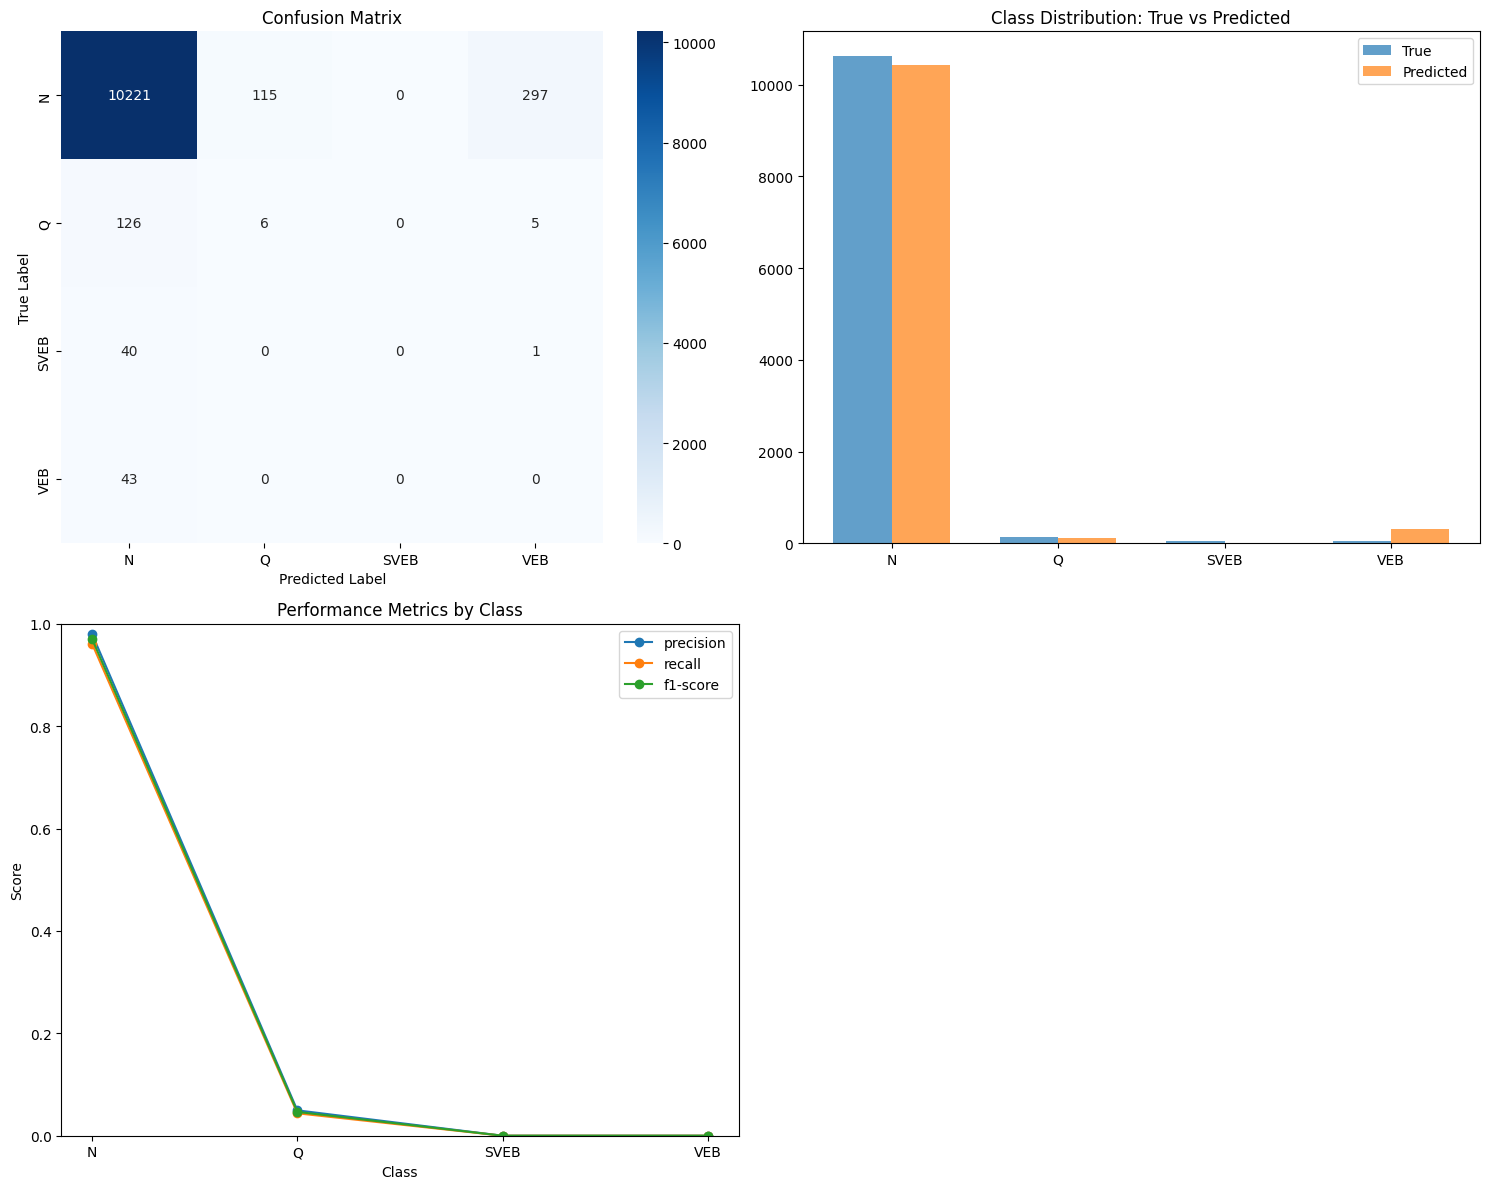


Detailed Class-wise Performance:
N: Precision=0.980, Recall=0.961, F1=0.971, Support=10633.0
Q: Precision=0.050, Recall=0.044, F1=0.047, Support=137.0
SVEB: Precision=0.000, Recall=0.000, F1=0.000, Support=41.0
VEB: Precision=0.000, Recall=0.000, F1=0.000, Support=43.0


In [13]:
# Main execution pipeline
def run_advanced_pipeline(X_train, y_train, X_test, y_test, X_val, y_val): # Added X_val, y_val
    # 1. Data augmentation for minority classes
    print("Augmenting minority classes...")
    # You might want to apply augmentation only to the training subset (X_train, y_train)
    # before splitting into train/val, or apply to the training part after the split.
    # For now, assuming augmentation is applied to the training data passed to this function.
    X_train_aug, y_train_aug = augment_minority_classes(X_train, y_train, target_samples=1000)

    # 2. Advanced feature engineering
    print("Extracting advanced features...")
    # (You'll need to modify your feature extraction to include advanced features)
    # This step would ideally happen *before* the train/val/test split

    # 3. Train advanced ensemble
    print("Training advanced ensemble...")
    # Ensure create_advanced_ensemble uses the augmented data
    advanced_ensemble = create_advanced_ensemble(X_train_aug, y_train_aug)

    # 4. Optimize thresholds
    print("Optimizing prediction thresholds...")
    # Ensure optimize_thresholds uses the validation data
    thresholds = optimize_thresholds(advanced_ensemble, X_val, y_val)

    # 5. Make predictions with optimized thresholds
    print("Making predictions with optimized thresholds...")
    # Ensure predictions are made on the test data
    final_proba = advanced_ensemble.predict_proba(X_test)
    # Apply optimized thresholds
    final_predictions = advanced_ensemble.classes_[np.argmax(final_proba, axis=1)]
    for cls, thresh in thresholds.items():
        # Find the index of the class in the model's classes_ array
        try:
            cls_idx = np.where(advanced_ensemble.classes_ == cls)[0][0]
            minority_mask = final_proba[:, cls_idx] > thresh
            final_predictions[minority_mask] = cls
        except ValueError:
            print(f"Warning: Class {cls} not found in model classes. Skipping threshold optimization for this class.")


    return final_predictions, advanced_ensemble, thresholds

# Add this section to perform the data split and run the pipeline
print("Splitting data into training, validation, and test sets...")
# Assuming X_train, y_train, X_test, y_test are already loaded from the previous steps

# Split training data into training and validation sets
# Use stratified split to maintain class distribution
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training split shape: {X_train_split.shape}, Validation set shape: {X_val.shape}, Test set shape: {X_test.shape}")


# Run the advanced pipeline with the split data
print("Running the advanced pipeline...")
final_predictions, best_model, optimal_thresholds = run_advanced_pipeline(
    X_train_split, y_train_split, X_test, y_test, X_val, y_val # Pass the split data
)

# Evaluate the final model
if final_predictions is not None and len(final_predictions) > 0:
    print("\nFinal Advanced Pipeline Performance:")
    print(classification_report(y_test, final_predictions, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, final_predictions))

    accuracy = accuracy_score(y_test, final_predictions)
    print(f"Final Accuracy: {accuracy:.4f}")

    # Save the final model and thresholds
    import joblib
    joblib.dump({
        'model': best_model,
        'thresholds': optimal_thresholds,
        'feature_selector': ecg_classifier_improved.feature_selector, # Assuming feature_selector is set by train_final_model
        'class_mapping': data_loader.aami_mapping,
        'performance': classification_report(y_test, final_predictions, output_dict=True)
    }, 'ecg_classifier_advanced_pipeline.pkl')

    print("Advanced pipeline model saved as 'ecg_classifier_advanced_pipeline.pkl'")

    # Plot results
    plot_results(y_test, final_predictions)

else:
    print("Advanced pipeline did not produce predictions.")

In [14]:
# Comprehensive evaluation
def comprehensive_evaluation(y_true, y_pred, model, X_test):
    """Complete model evaluation"""

    # Standard metrics
    print("Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.show()

    # ROC curves for each class
    from sklearn.metrics import roc_curve, auc
    probas = model.predict_proba(X_test)

    plt.figure(figsize=(12, 8))
    for i, cls in enumerate(model.classes_):
        if cls != 'N':  # Skip majority class for clarity
            fpr, tpr, _ = roc_curve((y_true == cls).astype(int), probas[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Minority Classes')
    plt.legend()
    plt.show()

    # Save final model
    joblib.dump({
        'model': best_model,
        'thresholds': optimal_thresholds,
        'feature_selector': feature_selector,
        'class_mapping': data_loader.aami_mapping,
        'performance': classification_report(y_true, y_pred, output_dict=True)
    }, 'ecg_classifier_production.pkl')

In [18]:
import gradio as gr
import numpy as np
import joblib
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import pywt
from biosppy.signals import ecg as biosppy_ecg
import os
from google.colab import drive

class ECGProcessor:
    def __init__(self, sampling_rate=360):
        self.sampling_rate = sampling_rate

    def preprocess_signal(self, signal):
        """Remove baseline wander"""
        window1 = int(0.2 * self.sampling_rate)
        window2 = int(0.6 * self.sampling_rate)
        window1 = window1 if window1 % 2 == 1 else window1 + 1
        window2 = window2 if window2 % 2 == 1 else window2 + 1

        baseline = medfilt(signal, window1)
        baseline = medfilt(baseline, window2)
        return signal - baseline

    def extract_wavelet_features(self, beat):
        """Extract wavelet features"""
        try:
            db1 = pywt.Wavelet('db1')
            coeffs = pywt.wavedec(beat, db1, level=3)
            return coeffs[0][:10]
        except:
            return np.zeros(10)

    def extract_hos_features(self, beat, n_intervals=6):
        """Extract Higher Order Statistics features"""
        winL, winR = 90, 90
        lag = int(round((winL + winR) / n_intervals))
        hos_features = np.zeros(10)

        for i in range(n_intervals-1):
            pos = lag * (i+1)
            start_idx = max(0, pos - (lag//2))
            end_idx = min(len(beat), pos + (lag//2))

            if end_idx > start_idx and (end_idx - start_idx) >= 3:
                interval = beat[start_idx:end_idx]
                mean_val = np.mean(interval)
                std_val = np.std(interval) + 1e-10
                hos_features[i] = np.mean((interval - mean_val)**3) / (std_val**3)
                hos_features[5+i] = np.mean((interval - mean_val)**4) / (std_val**4)

        return np.nan_to_num(hos_features)

    def extract_rr_intervals(self, r_peaks, current_index):
        """Extract RR interval features"""
        rr_features = np.zeros(8)
        if current_index > 0 and current_index < len(r_peaks) - 1:
            pre_RR = (r_peaks[current_index] - r_peaks[current_index-1]) / self.sampling_rate
            post_RR = (r_peaks[current_index+1] - r_peaks[current_index]) / self.sampling_rate
            local_RR = (r_peaks[current_index+1] - r_peaks[current_index-1]) / self.sampling_rate

            start_idx = max(0, current_index - 10)
            if current_index - start_idx > 0:
                global_RR = np.mean(np.diff(r_peaks[start_idx:current_index+1])) / self.sampling_rate
            else:
                global_RR = pre_RR

            rr_features[:4] = [pre_RR, post_RR, local_RR, global_RR]
        return np.nan_to_num(rr_features)

    def extract_features(self, signal):
        """Extract all features from ECG signal"""
        try:
            # Detect R-peaks
            rpeaks = biosppy_ecg.ecg(signal=signal, sampling_rate=self.sampling_rate, show=False)[2]

            processed_signal = self.preprocess_signal(signal)
            all_features = []
            winL, winR = 90, 90

            for i, r_pos in enumerate(rpeaks):
                if r_pos - winL < 0 or r_pos + winR >= len(processed_signal):
                    continue

                if i > 0:
                    rr_interval = (r_pos - rpeaks[i-1]) / self.sampling_rate
                    if rr_interval < 0.15 or rr_interval > 2.0:
                        continue

                beat = processed_signal[r_pos - winL: r_pos + winR]

                # Extract features
                raw_features = beat[::2]  # Downsample
                wavelet_features = self.extract_wavelet_features(beat)
                hos_features = self.extract_hos_features(beat)
                rr_features = self.extract_rr_intervals(rpeaks, i)

                combined_features = np.concatenate([
                    raw_features, wavelet_features, hos_features, rr_features
                ])

                if not np.any(np.isnan(combined_features)):
                    all_features.append(combined_features)

            if all_features:
                return np.mean(all_features, axis=0)  # Return average features
            else:
                return None

        except Exception as e:
            print(f"Feature extraction error: {e}")
            return None

# Load your trained model
def load_ecg_model():
    """Load the ECG classification model"""
    try:
        # Try different possible model paths
        possible_paths = [
            '/content/ECG_Data/app/models/ecg_classifier_advanced_pipeline.pkl',
            '/content/drive/MyDrive/ecg_classifier_advanced_pipeline.pkl',
            '/content/ecg_classifier_advanced_pipeline.pkl',
            '/content/drive/MyDrive/models/ecg_classifier_advanced_pipeline.pkl',
            'ecg_classifier_advanced_pipeline.pkl'
        ]

        for model_path in possible_paths:
            if os.path.exists(model_path):
                model_data = joblib.load(model_path)
                print(f"✅ Model loaded from: {model_path}")
                return model_data

        print("❌ Model file not found in any known location")
        return None

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

# Load model
model_data = load_ecg_model()

if model_data is None:
    print("Please train your model first or upload the model file to Google Drive")
    # You can add model training code here if needed

# AAMI class descriptions
CLASS_DESCRIPTIONS = {
    'N': 'Normal Beat',
    'SVEB': 'Supraventricular Ectopic Beat',
    'VEB': 'Ventricular Ectopic Beat',
    'F': 'Fusion Beat',
    'Q': 'Unknown Beat'
}

# Create ECG processor
ecg_processor = ECGProcessor()

def predict_ecg(ecg_signal):
    """Main prediction function for Gradio"""
    if model_data is None:
        return "❌ Model not loaded. Please train or upload model first.", None

    try:
        # Convert to numpy array
        ecg_array = np.array(ecg_signal, dtype=np.float64)

        # Validate input
        if len(ecg_array) < 360:
            return "❌ Signal too short. Need at least 1 second of data (360 samples).", None

        # Extract features
        features = ecg_processor.extract_features(ecg_array)

        if features is None:
            return "❌ Could not extract features. Check signal quality.", None

        # Get model components
        model = model_data['model']
        feature_selector = model_data.get('feature_selector')
        class_mapping = model_data.get('class_mapping', {})

        # Apply feature selection if available
        if feature_selector is not None:
            features = feature_selector.transform([features])

        # Make prediction
        prediction = model.predict([features])[0]
        probabilities = model.predict_proba([features])[0]

        # Create confidence scores
        confidence_scores = {
            model.classes_[i]: float(prob)
            for i, prob in enumerate(probabilities)
        }

        # Get class description
        class_desc = CLASS_DESCRIPTIONS.get(prediction, 'Unknown Beat')

        # Create result text
        result_text = f"""
        **Prediction:** {prediction} - {class_desc}
        **Confidence:** {confidence_scores.get(prediction, 0):.2%}

        **All Class Probabilities:**
        """

        for cls, prob in confidence_scores.items():
            cls_desc = CLASS_DESCRIPTIONS.get(cls, 'Unknown')
            result_text += f"\n- {cls}: {prob:.2%} ({cls_desc})"

        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot ECG signal
        ax1.plot(ecg_array[:1000])  # Show first 1000 samples
        ax1.set_title('Input ECG Signal')
        ax1.set_xlabel('Samples')
        ax1.set_ylabel('Amplitude')
        ax1.grid(True)

        # Plot confidence scores
        classes = list(confidence_scores.keys())
        probs = [confidence_scores[cls] for cls in classes]

        colors = ['green' if cls == prediction else 'blue' for cls in classes]
        ax2.bar(classes, probs, color=colors, alpha=0.7)
        ax2.set_title('Classification Confidence')
        ax2.set_ylabel('Probability')
        ax2.set_ylim(0, 1)

        plt.tight_layout()

        return result_text, fig

    except Exception as e:
        return f"❌ Error during prediction: {str(e)}", None

def generate_sample_ecg(beat_type):
    """Generate sample ECG signals for demonstration"""
    sample_rate = 360
    duration = 2  # seconds
    t = np.linspace(0, duration, sample_rate * duration)

    if beat_type == "Normal (N)":
        # Normal sinus rhythm
        signal = np.sin(2 * np.pi * 1.2 * t) + 0.5 * np.sin(2 * np.pi * 5 * t)
    elif beat_type == "Ventricular (VEB)":
        # Ventricular ectopic beat - wider QRS complex
        signal = 1.5 * np.sin(2 * np.pi * 0.8 * t) * np.exp(-2 * t)
    elif beat_type == "Supraventricular (SVEB)":
        # Supraventricular ectopic beat - abnormal P wave
        signal = np.sin(2 * np.pi * 1.5 * t) + 0.3 * np.sin(2 * np.pi * 8 * t)
    else:
        # Unknown beat
        signal = 0.8 * np.sin(2 * np.pi * 1.0 * t) + 0.2 * np.random.randn(len(t))

    # Add some noise to make it realistic
    signal = signal + 0.1 * np.random.randn(len(t))

    return signal.tolist()

# Create Gradio interface
with gr.Blocks(title="ECG Arrhythmia Classifier", theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🫀 ECG Arrhythmia Classification")
    gr.Markdown("Upload an ECG signal or use sample data to classify heartbeats according to AAMI standards")

    with gr.Row():
        with gr.Column():
            gr.Markdown("## 📊 Input ECG Signal")

            # Sample selector
            sample_selector = gr.Dropdown(
                choices=["Normal (N)", "Ventricular (VEB)", "Supraventricular (SVEB)", "Unknown"],
                label="Select Sample ECG Type",
                value="Normal (N)"
            )

            # ECG signal input
            ecg_input = gr.Textbox(
                label="ECG Signal (comma-separated values)",
                placeholder="Enter ECG values separated by commas...",
                lines=3
            )

            # File upload
            file_upload = gr.File(
                label="Or upload ECG data file (CSV/TXT)",
                file_types=[".csv", ".txt"]
            )

            # Generate sample button
            generate_btn = gr.Button("🎲 Generate Sample ECG")

            # Predict button
            predict_btn = gr.Button("🔍 Analyze ECG", variant="primary")

        with gr.Column():
            gr.Markdown("## 📈 Results")

            # Output text
            result_output = gr.Markdown(label="Classification Results")

            # Output plot
            plot_output = gr.Plot(label="Visualization")

    # Function calls
    generate_btn.click(
        fn=generate_sample_ecg,
        inputs=sample_selector,
        outputs=ecg_input
    )

    predict_btn.click(
        fn=predict_ecg,
        inputs=ecg_input,
        outputs=[result_output, plot_output]
    )

    # File upload handling
    def process_uploaded_file(file):
        try:
            if file is None:
                return ""

            # Read file content
            if hasattr(file, 'read'):
                content = file.read().decode('utf-8')
            else:
                with open(file.name, 'r') as f:
                    content = f.read()

            # Try to parse as CSV or simple list
            lines = content.strip().split('\n')

            # If it's CSV with header, skip first line
            if len(lines) > 1 and any(char in lines[0] for char in [',', ';', '\t']):
                # Assume first line is header
                ecg_data = []
                for line in lines[1:]:
                    if line.strip():
                        # Take first column or split by commas
                        parts = line.split(',')
                        if parts:
                            try:
                                ecg_data.append(float(parts[0].strip()))
                            except:
                                pass
            else:
                # Simple list of numbers
                ecg_data = []
                for line in lines:
                    if line.strip():
                        try:
                            ecg_data.append(float(line.strip()))
                        except:
                            pass

            return ",".join(map(str, ecg_data))

        except Exception as e:
            return f"Error reading file: {str(e)}"

    file_upload.upload(
        fn=process_uploaded_file,
        inputs=file_upload,
        outputs=ecg_input
    )

# Launch the interface
print("🚀 Launching Gradio Interface...")
print("📋 You can:")
print("   - Generate sample ECG signals")
print("   - Paste your own ECG data (comma-separated)")
print("   - Upload CSV/TXT files with ECG data")
print("   - Get instant classification results!")

demo.launch(share=True)  # share=True creates a public link

✅ Model loaded from: /content/ecg_classifier_advanced_pipeline.pkl
🚀 Launching Gradio Interface...
📋 You can:
   - Generate sample ECG signals
   - Paste your own ECG data (comma-separated)
   - Upload CSV/TXT files with ECG data
   - Get instant classification results!
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cb1647eca9ae3005b9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [20]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.1 MB/s eta 0:00:00


In [24]:
# ecg_app.py
import warnings
warnings.filterwarnings("ignore")

import streamlit as st
import numpy as np
import joblib
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import pywt
from biosppy.signals import ecg as biosppy_ecg
import os
import pandas as pd
from io import StringIO

# Initialize session state
if 'ecg_data' not in st.session_state:
    st.session_state.ecg_data = None
if 'data_source' not in st.session_state:
    st.session_state.data_source = None
if 'prediction' not in st.session_state:
    st.session_state.prediction = None
if 'confidence_scores' not in st.session_state:
    st.session_state.confidence_scores = None
if 'ecg_array' not in st.session_state:
    st.session_state.ecg_array = None

# Set page config - MUST be first Streamlit command
st.set_page_config(
    page_title="ECG Arrhythmia Classifier",
    page_icon="🫀",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS
st.markdown("""
<style>
    .main-header {
        font-size: 3rem;
        color: #1f77b4;
        text-align: center;
        margin-bottom: 2rem;
    }
    .result-box {
        background-color: #f0f2f6;
        padding: 2rem;
        border-radius: 10px;
        margin-top: 2rem;
    }
    .prediction-card {
        background: white;
        padding: 1.5rem;
        border-radius: 10px;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        margin: 1rem 0;
    }
</style>
""", unsafe_allow_html=True)

class ECGProcessor:
    def __init__(self, sampling_rate=360):
        self.sampling_rate = sampling_rate

    def preprocess_signal(self, signal):
        """Remove baseline wander"""
        window1 = int(0.2 * self.sampling_rate)
        window2 = int(0.6 * self.sampling_rate)
        window1 = window1 if window1 % 2 == 1 else window1 + 1
        window2 = window2 if window2 % 2 == 1 else window2 + 1

        baseline = medfilt(signal, window1)
        baseline = medfilt(baseline, window2)
        return signal - baseline

    def extract_wavelet_features(self, beat):
        """Extract wavelet features"""
        try:
            db1 = pywt.Wavelet('db1')
            coeffs = pywt.wavedec(beat, db1, level=3)
            return coeffs[0][:10]
        except:
            return np.zeros(10)

    def extract_hos_features(self, beat, n_intervals=6):
        """Extract Higher Order Statistics features"""
        winL, winR = 90, 90
        lag = int(round((winL + winR) / n_intervals))
        hos_features = np.zeros(10)

        for i in range(n_intervals-1):
            pos = lag * (i+1)
            start_idx = max(0, pos - (lag//2))
            end_idx = min(len(beat), pos + (lag//2))

            if end_idx > start_idx and (end_idx - start_idx) >= 3:
                interval = beat[start_idx:end_idx]
                mean_val = np.mean(interval)
                std_val = np.std(interval) + 1e-10
                hos_features[i] = np.mean((interval - mean_val)**3) / (std_val**3)
                hos_features[5+i] = np.mean((interval - mean_val)**4) / (std_val**4)

        return np.nan_to_num(hos_features)

    def extract_rr_intervals(self, r_peaks, current_index):
        """Extract RR interval features"""
        rr_features = np.zeros(8)
        if current_index > 0 and current_index < len(r_peaks) - 1:
            pre_RR = (r_peaks[current_index] - r_peaks[current_index-1]) / self.sampling_rate
            post_RR = (r_peaks[current_index+1] - r_peaks[current_index]) / self.sampling_rate
            local_RR = (r_peaks[current_index+1] - r_peaks[current_index-1]) / self.sampling_rate

            start_idx = max(0, current_index - 10)
            if current_index - start_idx > 0:
                global_RR = np.mean(np.diff(r_peaks[start_idx:current_index+1])) / self.sampling_rate
            else:
                global_RR = pre_RR

            rr_features[:4] = [pre_RR, post_RR, local_RR, global_RR]
        return np.nan_to_num(rr_features)

    def extract_features(self, signal):
        """Extract all features from ECG signal"""
        try:
            # Detect R-peaks
            rpeaks = biosppy_ecg.ecg(signal=signal, sampling_rate=self.sampling_rate, show=False)[2]

            processed_signal = self.preprocess_signal(signal)
            all_features = []
            winL, winR = 90, 90

            for i, r_pos in enumerate(rpeaks):
                if r_pos - winL < 0 or r_pos + winR >= len(processed_signal):
                    continue

                if i > 0:
                    rr_interval = (r_pos - rpeaks[i-1]) / self.sampling_rate
                    if rr_interval < 0.15 or rr_interval > 2.0:
                        continue

                beat = processed_signal[r_pos - winL: r_pos + winR]

                # Extract features
                raw_features = beat[::2]  # Downsample
                wavelet_features = self.extract_wavelet_features(beat)
                hos_features = self.extract_hos_features(beat)
                rr_features = self.extract_rr_intervals(rpeaks, i)

                combined_features = np.concatenate([
                    raw_features, wavelet_features, hos_features, rr_features
                ])

                if not np.any(np.isnan(combined_features)):
                    all_features.append(combined_features)

            if all_features:
                return np.mean(all_features, axis=0)  # Return average features
            else:
                return None

        except Exception as e:
            st.error(f"Feature extraction error: {e}")
            return None

# Load model function
@st.cache_resource
def load_ecg_model():
    """Load the ECG classification model"""
    try:
        possible_paths = [
            'ecg_classifier_advanced_pipeline.pkl',
            '/content/ecg_classifier_advanced_pipeline.pkl',
            './models/ecg_classifier_advanced_pipeline.pkl',
            'ecg_classifier_production.pkl'
        ]

        for model_path in possible_paths:
            if os.path.exists(model_path):
                model_data = joblib.load(model_path)
                st.success(f"✅ Model loaded from: {model_path}")
                return model_data

        st.error("❌ Model file not found")
        return None

    except Exception as e:
        st.error(f"❌ Error loading model: {e}")
        return None

# AAMI class descriptions
CLASS_DESCRIPTIONS = {
    'N': {'name': 'Normal Beat', 'color': 'green'},
    'SVEB': {'name': 'Supraventricular Ectopic Beat', 'color': 'orange'},
    'VEB': {'name': 'Ventricular Ectopic Beat', 'color': 'red'},
    'F': {'name': 'Fusion Beat', 'color': 'purple'},
    'Q': {'name': 'Unknown Beat', 'color': 'gray'}
}

def predict_ecg(ecg_signal):
    """Main prediction function"""
    model_data = load_ecg_model()
    ecg_processor = ECGProcessor()

    if model_data is None:
        return None, None, None

    try:
        ecg_array = np.array(ecg_signal, dtype=np.float64)

        if len(ecg_array) < 360:
            st.warning("⚠️ Signal too short. Need at least 360 samples.")
            return None, None, None

        features = ecg_processor.extract_features(ecg_array)

        if features is None:
            st.warning("⚠️ Could not extract features.")
            return None, None, None

        model = model_data['model']
        feature_selector = model_data.get('feature_selector')

        if feature_selector is not None:
            features = feature_selector.transform([features])

        prediction = model.predict([features])[0]
        probabilities = model.predict_proba([features])[0]

        confidence_scores = {
            model.classes_[i]: float(prob)
            for i, prob in enumerate(probabilities)
        }

        return prediction, confidence_scores, ecg_array

    except Exception as e:
        st.error(f"❌ Prediction error: {e}")
        return None, None, None

def generate_sample_ecg(beat_type):
    """Generate sample ECG signals"""
    sample_rate = 360
    duration = 2
    t = np.linspace(0, duration, sample_rate * duration)

    if beat_type == "Normal (N)":
        signal = np.sin(2 * np.pi * 1.2 * t) + 0.5 * np.sin(2 * np.pi * 5 * t)
    elif beat_type == "Ventricular (VEB)":
        signal = 1.5 * np.sin(2 * np.pi * 0.8 * t) * np.exp(-2 * t)
    elif beat_type == "Supraventricular (SVEB)":
        signal = np.sin(2 * np.pi * 1.5 * t) + 0.3 * np.sin(2 * np.pi * 8 * t)
    else:
        signal = 0.8 * np.sin(2 * np.pi * 1.0 * t) + 0.2 * np.random.randn(len(t))

    return signal.tolist()

def main():
    st.markdown('<h1 class="main-header">🫀 ECG Arrhythmia Classifier</h1>', unsafe_allow_html=True)
    st.markdown("Classify ECG signals using machine learning")

    # Sidebar
    with st.sidebar:
        st.header("⚙️ Settings")

        st.subheader("📊 Sample Data")
        sample_type = st.selectbox(
            "Select sample type:",
            ["Normal (N)", "Ventricular (VEB)", "Supraventricular (SVEB)", "Unknown"],
            index=0
        )

        if st.button("🎲 Generate Sample"):
            sample_data = generate_sample_ecg(sample_type)
            st.session_state.ecg_data = sample_data
            st.session_state.data_source = "sample"
            st.rerun()

        st.subheader("📁 Upload Data")
        uploaded_file = st.file_uploader(
            "Upload CSV/TXT file:",
            type=['csv', 'txt']
        )

        if uploaded_file is not None:
            try:
                content = uploaded_file.getvalue().decode('utf-8')
                ecg_data = []
                for line in content.strip().split('\n'):
                    for val in line.split(','):
                        if val.strip():
                            try:
                                ecg_data.append(float(val.strip()))
                            except:
                                pass

                if ecg_data:
                    st.session_state.ecg_data = ecg_data
                    st.session_state.data_source = "upload"
                    st.rerun()

            except Exception as e:
                st.error(f"Error reading file: {e}")

    # Main content
    col1, col2 = st.columns([1, 1])

    with col1:
        st.header("📈 Input ECG Signal")

        ecg_input = st.text_area(
            "Paste ECG values (comma-separated):",
            height=100,
            placeholder="-0.12, -0.08, -0.03, 0.02, 0.12, 0.25..."
        )

        if st.button("📥 Load Manual Data") and ecg_input:
            try:
                ecg_data = [float(x.strip()) for x in ecg_input.split(',') if x.strip()]
                st.session_state.ecg_data = ecg_data
                st.session_state.data_source = "manual"
                st.rerun()
            except:
                st.error("❌ Invalid format")

        if st.session_state.ecg_data is not None:
            st.subheader("Current ECG Data")
            st.write(f"**Data points:** {len(st.session_state.ecg_data)}")

            fig, ax = plt.subplots(figsize=(10, 4))
            ax.plot(st.session_state.ecg_data[:1000])
            ax.set_title('ECG Signal Preview')
            ax.set_xlabel('Samples')
            ax.set_ylabel('Amplitude')
            ax.grid(True)
            st.pyplot(fig)

            if st.button("🔍 Analyze ECG", type="primary"):
                with st.spinner("Analyzing..."):
                    prediction, confidence_scores, ecg_array = predict_ecg(st.session_state.ecg_data)

                    if prediction is not None:
                        st.session_state.prediction = prediction
                        st.session_state.confidence_scores = confidence_scores
                        st.session_state.ecg_array = ecg_array
                        st.rerun()

    with col2:
        st.header("📊 Results")

        if st.session_state.prediction is not None:
            prediction = st.session_state.prediction
            confidence_scores = st.session_state.confidence_scores
            confidence = confidence_scores.get(prediction, 0)
            pred_info = CLASS_DESCRIPTIONS.get(prediction, {'name': 'Unknown', 'color': 'gray'})

            st.markdown(f"""
            <div class="prediction-card">
                <h2 style="color: {pred_info['color']}; text-align: center;">
                    {prediction} - {pred_info['name']}
                </h2>
                <h3 style="text-align: center;">
                    Confidence: {confidence:.2%}
                </h3>
            </div>
            """, unsafe_allow_html=True)

            st.subheader("Confidence Scores")
            for cls, prob in sorted(confidence_scores.items(), key=lambda x: x[1], reverse=True):
                cls_info = CLASS_DESCRIPTIONS.get(cls, {'name': cls, 'color': 'gray'})
                st.progress(prob, text=f"{cls}: {prob:.2%} ({cls_info['name']})")

            # Visualization
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

            ax1.plot(st.session_state.ecg_array[:1000])
            ax1.set_title('ECG Signal')
            ax1.grid(True)

            classes = list(confidence_scores.keys())
            probs = [confidence_scores[cls] for cls in classes]
            colors = [CLASS_DESCRIPTIONS.get(cls, {'color': 'blue'})['color'] for cls in classes]

            bars = ax2.bar(classes, probs, color=colors, alpha=0.7)
            ax2.set_title('Classification Confidence')
            ax2.set_ylim(0, 1)

            for bar, prob in zip(bars, probs):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{prob:.2%}', ha='center', va='bottom')

            plt.tight_layout()
            st.pyplot(fig)

        else:
            st.info("👆 Load ECG data and click 'Analyze ECG'")

# Run the app
if __name__ == "__main__":
    main()

2025-09-08 05:11:15.823 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-08 05:11:15.824 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-08 05:11:15.827 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-08 05:11:15.831 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-08 05:11:15.832 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-08 05:11:15.834 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-08 05:11:15.838 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-08 05:11:15.839 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [30]:
# Install requirements
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 39.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [32]:
# Run the app
!streamlit run ecg_app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.187.226.152:8501

  Stopping...
  Stopping...


In [31]:
# Save the Streamlit app code to a file
streamlit_code = """
import warnings
warnings.filterwarnings("ignore")

import streamlit as st
import numpy as np
import joblib
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import pywt
from biosppy.signals import ecg as biosppy_ecg
import os
import pandas as pd
from io import StringIO

# Initialize session state
if 'ecg_data' not in st.session_state:
    st.session_state.ecg_data = None
if 'data_source' not in st.session_state:
    st.session_state.data_source = None
if 'prediction' not in st.session_state:
    st.session_state.prediction = None
if 'confidence_scores' not in st.session_state:
    st.session_state.confidence_scores = None
if 'ecg_array' not in st.session_state:
    st.session_state.ecg_array = None

# Set page config - MUST be first Streamlit command
st.set_page_config(
    page_title="ECG Arrhythmia Classifier",
    page_icon="🫀",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS
st.markdown(\"\"\"
<style>
    .main-header {
        font-size: 3rem;
        color: #1f77b4;
        text-align: center;
        margin-bottom: 2rem;
    }
    .result-box {
        background-color: #f0f2f6;
        padding: 2rem;
        border-radius: 10px;
        margin-top: 2rem;
    }
    .prediction-card {
        background: white;
        padding: 1.5rem;
        border-radius: 10px;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        margin: 1rem 0;
    }
</style>
\"\"\", unsafe_allow_html=True)

class ECGProcessor:
    def __init__(self, sampling_rate=360):
        self.sampling_rate = sampling_rate

    def preprocess_signal(self, signal):
        \"\"\"Remove baseline wander\"\"\"
        window1 = int(0.2 * self.sampling_rate)
        window2 = int(0.6 * self.sampling_rate)
        window1 = window1 if window1 % 2 == 1 else window1 + 1
        window2 = window2 if window2 % 2 == 1 else window2 + 1

        baseline = medfilt(signal, window1)
        baseline = medfilt(baseline, window2)
        return signal - baseline

    def extract_wavelet_features(self, beat):
        \"\"\"Extract wavelet features\"\"\"
        try:
            db1 = pywt.Wavelet('db1')
            coeffs = pywt.wavedec(beat, db1, level=3)
            return coeffs[0][:10]
        except:
            return np.zeros(10)

    def extract_hos_features(self, beat, n_intervals=6):
        \"\"\"Extract Higher Order Statistics features\"\"\"
        winL, winR = 90, 90
        lag = int(round((winL + winR) / n_intervals))
        hos_features = np.zeros(10)

        for i in range(n_intervals-1):
            pos = lag * (i+1)
            start_idx = max(0, pos - (lag//2))
            end_idx = min(len(beat), pos + (lag//2))

            if end_idx > start_idx and (end_idx - start_idx) >= 3:
                interval = beat[start_idx:end_idx]
                mean_val = np.mean(interval)
                std_val = np.std(interval) + 1e-10
                hos_features[i] = np.mean((interval - mean_val)**3) / (std_val**3)
                hos_features[5+i] = np.mean((interval - mean_val)**4) / (std_val**4)

        return np.nan_to_num(hos_features)

    def extract_rr_intervals(self, r_peaks, current_index):
        \"\"\"Extract RR interval features\"\"\"
        rr_features = np.zeros(8)
        if current_index > 0 and current_index < len(r_peaks) - 1:
            pre_RR = (r_peaks[current_index] - r_peaks[current_index-1]) / self.sampling_rate
            post_RR = (r_peaks[current_index+1] - r_peaks[current_index]) / self.sampling_rate
            local_RR = (r_peaks[current_index+1] - r_peaks[current_index-1]) / self.sampling_rate

            start_idx = max(0, current_index - 10)
            if current_index - start_idx > 0:
                global_RR = np.mean(np.diff(r_peaks[start_idx:current_index+1])) / self.sampling_rate
            else:
                global_RR = pre_RR

            rr_features[:4] = [pre_RR, post_RR, local_RR, global_RR]
        return np.nan_to_num(rr_features)

    def extract_features(self, signal):
        \"\"\"Extract all features from ECG signal\"\"\"
        try:
            # Detect R-peaks
            rpeaks = biosppy_ecg.ecg(signal=signal, sampling_rate=self.sampling_rate, show=False)[2]

            processed_signal = self.preprocess_signal(signal)
            all_features = []
            winL, winR = 90, 90

            for i, r_pos in enumerate(rpeaks):
                if r_pos - winL < 0 or r_pos + winR >= len(processed_signal):
                    continue

                if i > 0:
                    rr_interval = (r_pos - rpeaks[i-1]) / self.sampling_rate
                    if rr_interval < 0.15 or rr_interval > 2.0:
                        continue

                beat = processed_signal[r_pos - winL: r_pos + winR]

                # Extract features
                raw_features = beat[::2]  # Downsample
                wavelet_features = self.extract_wavelet_features(beat)
                hos_features = self.extract_hos_features(beat)
                rr_features = self.extract_rr_intervals(rpeaks, i)

                combined_features = np.concatenate([
                    raw_features, wavelet_features, hos_features, rr_features
                ])

                if not np.any(np.isnan(combined_features)):
                    all_features.append(combined_features)

            if all_features:
                return np.mean(all_features, axis=0)  # Return average features
            else:
                return None

        except Exception as e:
            st.error(f"Feature extraction error: {e}")
            return None

# Load model function
@st.cache_resource
def load_ecg_model():
    \"\"\"Load the ECG classification model\"\"\"
    try:
        possible_paths = [
            'ecg_classifier_advanced_pipeline.pkl',
            '/content/ecg_classifier_advanced_pipeline.pkl',
            './models/ecg_classifier_advanced_pipeline.pkl',
            'ecg_classifier_production.pkl'
        ]

        for model_path in possible_paths:
            if os.path.exists(model_path):
                model_data = joblib.load(model_path)
                st.success(f"✅ Model loaded from: {model_path}")
                return model_data

        st.error("❌ Model file not found")
        return None

    except Exception as e:
        st.error(f"❌ Error loading model: {e}")
        return None

# AAMI class descriptions
CLASS_DESCRIPTIONS = {
    'N': {'name': 'Normal Beat', 'color': 'green'},
    'SVEB': {'name': 'Supraventricular Ectopic Beat', 'color': 'orange'},
    'VEB': {'name': 'Ventricular Ectopic Beat', 'color': 'red'},
    'F': {'name': 'Fusion Beat', 'color': 'purple'},
    'Q': {'name': 'Unknown Beat', 'color': 'gray'}
}

def predict_ecg(ecg_signal):
    \"\"\"Main prediction function\"\"\"
    model_data = load_ecg_model()
    ecg_processor = ECGProcessor()

    if model_data is None:
        return None, None, None

    try:
        ecg_array = np.array(ecg_signal, dtype=np.float64)

        if len(ecg_array) < 360:
            st.warning("⚠️ Signal too short. Need at least 360 samples.")
            return None, None, None

        features = ecg_processor.extract_features(ecg_array)

        if features is None:
            st.warning("⚠️ Could not extract features.")
            return None, None, None

        model = model_data['model']
        feature_selector = model_data.get('feature_selector')

        if feature_selector is not None:
            # Ensure features is 2D for transformation
            features = feature_selector.transform(features.reshape(1, -1))


        prediction = model.predict(features)[0]
        probabilities = model.predict_proba(features)[0]

        confidence_scores = {
            model.classes_[i]: float(prob)
            for i, prob in enumerate(probabilities)
        }

        return prediction, confidence_scores, ecg_array

    except Exception as e:
        st.error(f"❌ Prediction error: {e}")
        return None, None, None

def generate_sample_ecg(beat_type):
    \"\"\"Generate sample ECG signals\"\"\"
    sample_rate = 360
    duration = 2
    t = np.linspace(0, duration, sample_rate * duration)

    if beat_type == "Normal (N)":
        signal = np.sin(2 * np.pi * 1.2 * t) + 0.5 * np.sin(2 * np.pi * 5 * t)
    elif beat_type == "Ventricular (VEB)":
        signal = 1.5 * np.sin(2 * np.pi * 0.8 * t) * np.exp(-2 * t)
    elif beat_type == "Supraventricular (SVEB)":
        signal = np.sin(2 * np.pi * 1.5 * t) + 0.3 * np.sin(2 * np.pi * 8 * t)
    else:
        signal = 0.8 * np.sin(2 * np.pi * 1.0 * t) + 0.2 * np.random.randn(len(t))

    return signal.tolist()

def main():
    st.markdown('<h1 class="main-header">🫀 ECG Arrhythmia Classifier</h1>', unsafe_allow_html=True)
    st.markdown("Classify ECG signals using machine learning")

    # Sidebar
    with st.sidebar:
        st.header("⚙️ Settings")

        st.subheader("📊 Sample Data")
        sample_type = st.selectbox(
            "Select sample type:",
            ["Normal (N)", "Ventricular (VEB)", "Supraventricular (SVEB)", "Unknown"],
            index=0
        )

        if st.button("🎲 Generate Sample"):
            sample_data = generate_sample_ecg(sample_type)
            st.session_state.ecg_data = sample_data
            st.session_state.data_source = "sample"
            st.session_state.prediction = None # Clear previous results
            st.session_state.confidence_scores = None
            st.session_state.ecg_array = None
            st.rerun()

        st.subheader("📁 Upload Data")
        uploaded_file = st.file_uploader(
            "Upload CSV/TXT file:",
            type=['csv', 'txt']
        )

        if uploaded_file is not None:
            try:
                content = uploaded_file.getvalue().decode('utf-8')
                ecg_data = []
                for line in content.strip().split('\\n'):
                    for val in line.split(','):
                        if val.strip():
                            try:
                                ecg_data.append(float(val.strip()))
                            except:
                                pass

                if ecg_data:
                    st.session_state.ecg_data = ecg_data
                    st.session_state.data_source = "upload"
                    st.session_state.prediction = None # Clear previous results
                    st.session_state.confidence_scores = None
                    st.session_state.ecg_array = None
                    st.rerun()

            except Exception as e:
                st.error(f"Error reading file: {e}")

    # Main content
    col1, col2 = st.columns([1, 1])

    with col1:
        st.header("📈 Input ECG Signal")

        ecg_input = st.text_area(
            "Paste ECG values (comma-separated):",
            height=100,
            placeholder="-0.12, -0.08, -0.03, 0.02, 0.12, 0.25..."
        )

        if st.button("📥 Load Manual Data") and ecg_input:
            try:
                ecg_data = [float(x.strip()) for x in ecg_input.split(',') if x.strip()]
                st.session_state.ecg_data = ecg_data
                st.session_state.data_source = "manual"
                st.session_state.prediction = None # Clear previous results
                st.session_state.confidence_scores = None
                st.session_state.ecg_array = None
                st.rerun()
            except:
                st.error("❌ Invalid format")

        if st.session_state.ecg_data is not None:
            st.subheader("Current ECG Data Preview")
            st.write(f"**Data points:** {len(st.session_state.ecg_data)}")

            fig, ax = plt.subplots(figsize=(10, 4))
            ax.plot(st.session_state.ecg_data[:min(len(st.session_state.ecg_data), 1000)]) # Limit preview
            ax.set_title('ECG Signal Preview')
            ax.set_xlabel('Samples')
            ax.set_ylabel('Amplitude')
            ax.grid(True)
            st.pyplot(fig)
            plt.close(fig) # Close figure to prevent display issues

            if st.button("🔍 Analyze ECG", type="primary"):
                with st.spinner("Analyzing..."):
                    prediction, confidence_scores, ecg_array = predict_ecg(st.session_state.ecg_data)

                    if prediction is not None:
                        st.session_state.prediction = prediction
                        st.session_state.confidence_scores = confidence_scores
                        st.session_state.ecg_array = ecg_array
                        st.rerun()

    with col2:
        st.header("📊 Results")

        if st.session_state.prediction is not None:
            prediction = st.session_state.prediction
            confidence_scores = st.session_state.confidence_scores
            confidence = confidence_scores.get(prediction, 0)
            pred_info = CLASS_DESCRIPTIONS.get(prediction, {'name': 'Unknown', 'color': 'gray'})

            st.markdown(f\"\"\"
            <div class="prediction-card">
                <h2 style="color: {pred_info['color']}; text-align: center;">
                    {prediction} - {pred_info['name']}
                </h2>
                <h3 style="text-align: center;">
                    Confidence: {confidence:.2%}
                </h3>
            </div>
            \"\"\", unsafe_allow_html=True)

            st.subheader("Confidence Scores")
            for cls, prob in sorted(confidence_scores.items(), key=lambda x: x[1], reverse=True):
                cls_info = CLASS_DESCRIPTIONS.get(cls, {'name': cls, 'color': 'gray'})
                st.progress(prob, text=f"{cls}: {prob:.2%} ({cls_info['name']})")

            # Visualization
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

            ax1.plot(st.session_state.ecg_array[:min(len(st.session_state.ecg_array), 1000)]) # Limit plot
            ax1.set_title('ECG Signal')
            ax1.set_xlabel('Samples')
            ax1.set_ylabel('Amplitude')
            ax1.grid(True)

            classes = list(confidence_scores.keys())
            probs = [confidence_scores[cls] for cls in classes]
            colors = [CLASS_DESCRIPTIONS.get(cls, {'color': 'blue'})['color'] for cls in classes]

            bars = ax2.bar(classes, probs, color=colors, alpha=0.7)
            ax2.set_title('Classification Confidence')
            ax2.set_ylim(0, 1)

            for bar, prob in zip(bars, probs):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{prob:.2%}', ha='center', va='bottom')

            plt.tight_layout()
            st.pyplot(fig)
            plt.close(fig) # Close figure

        else:
            st.info("👆 Load ECG data and click 'Analyze ECG'")

# Run the app
if __name__ == "__main__":
    main()
"""

with open("ecg_app.py", "w") as f:
    f.write(streamlit_code)

print("ecg_app.py created successfully.")

ecg_app.py created successfully.
